In [3]:
!mkdir -p /usr/local/lib/python3.12/dist-packages/aif360/data/raw/compas
!wget -O /usr/local/lib/python3.12/dist-packages/aif360/data/raw/compas/compas-scores-two-years.csv \
https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv


--2025-11-24 06:57:50--  https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546489 (2.4M) [text/plain]
Saving to: ‘/usr/local/lib/python3.12/dist-packages/aif360/data/raw/compas/compas-scores-two-years.csv’

/usr/local/lib/pyth 100%[===================>]   2.43M  --.-KB/s    in 0.01s   

2025-11-24 06:57:50 (187 MB/s) - ‘/usr/local/lib/python3.12/dist-packages/aif360/data/raw/compas/compas-scores-two-years.csv’ saved [2546489/2546489]



In [4]:
# AI Fairness 360 + COMPAS Dataset Audit
# Notebook: COMPAS Bias Audit

# Install required libraries (run once)
# !pip install aif360 pandas matplotlib seaborn scikit-learn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from aif360.algorithms.preprocessing import OptimPreproc


In [5]:
# Load COMPAS dataset
compas = CompasDataset()

# Check basic info
print(compas.features[:5])
print(compas.labels[:5])
print(compas.protected_attribute_names)

[[ 0. 69.  0. ...  0.  0.  0.]
 [ 0. 34.  0. ...  0.  0.  0.]
 [ 0. 24.  0. ...  0.  0.  0.]
 [ 0. 44.  0. ...  0.  0.  0.]
 [ 0. 41.  1. ...  0.  0.  0.]]
[[0.]
 [1.]
 [1.]
 [0.]
 [1.]]
['sex', 'race']


In [6]:
# Split dataset
train, test = compas.split([0.7], shuffle=True)

In [7]:
# Apply Reweighing (bias mitigation)
rw = Reweighing(unprivileged_groups=[{'race': 1}], privileged_groups=[{'race': 0}])
rw.fit(train)
train_transf = rw.transform(train)

In [8]:
# Train a Logistic Regression model
X_train = train_transf.features
y_train = train_transf.labels.ravel()
X_test = test.features
y_test = test.labels.ravel()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [9]:
# Convert predictions to AIF360 dataset
from aif360.datasets import BinaryLabelDataset
test_pred = test.copy()
test_pred.labels = y_pred

In [10]:
# Compute fairness metrics
metric = ClassificationMetric(test, test_pred,
                              unprivileged_groups=[{'race': 1}],
                              privileged_groups=[{'race': 0}])

print("Disparate Impact:", metric.disparate_impact())
print("False Positive Rate Difference:", metric.false_positive_rate_difference())
print("Statistical Parity Difference:", metric.statistical_parity_difference())

Disparate Impact: 1.3160341813359056
False Positive Rate Difference: 0.17017539975944335
Statistical Parity Difference: 0.16432747163187267


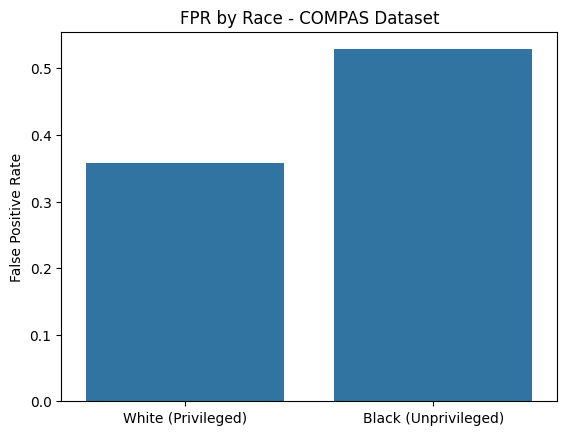

In [11]:
# Visualization of False Positive Rates by race
fpr_priv = metric.false_positive_rate(privileged=True)
fpr_unpriv = metric.false_positive_rate(privileged=False)

sns.barplot(x=['White (Privileged)', 'Black (Unprivileged)'], y=[fpr_priv, fpr_unpriv])
plt.ylabel("False Positive Rate")
plt.title("FPR by Race - COMPAS Dataset")
plt.show()